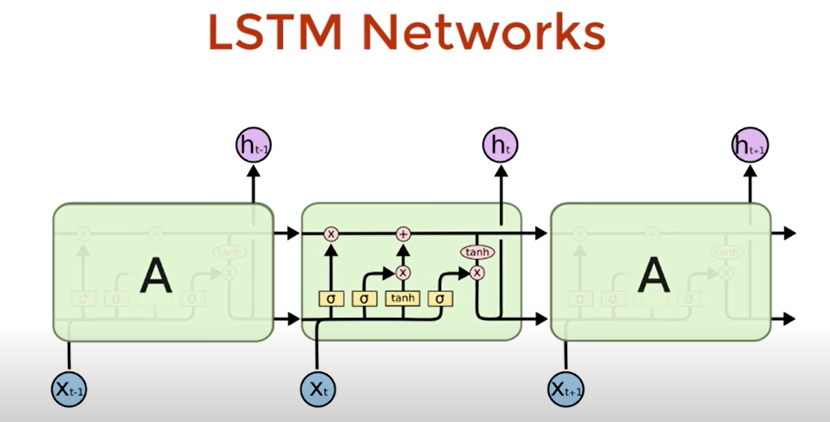

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import nltk
import time
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [ ]:
df=pd.read_csv("/content/dp_best.csv",header=None)

In [ ]:
# changing to lowercase
df[0] = df[0].str.lower()

# removing urls
df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)

# removing new lines "\n"
df[0] = df[0].str.replace('\n',' ', regex=True)

# removing all the punctuations
df[0] = df[0].str.replace('[^\w\s]',' ')

# removing integers
df[0] = df[0].str.replace('\d','', regex=True)

# removing emojis
df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)

<ipython-input-3-cdd03867b11b>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)
<ipython-input-3-cdd03867b11b>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('[^\w\s]',' ')
<ipython-input-3-cdd03867b11b>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

df[0] = df[0].apply(lambda text: cleaning_stopwords(text))

df[0].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0               thanks like deals
1           rather pay full price
2                  like discounts
3         thanks like great deals
4    thanks rather pay full price
Name: 0, dtype: object

In [ ]:
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df[0] = df[0].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
sentiment_mapping = {
    'Shaming': 0,
    'False Urgency': 1,
    'Nagging': 2,
    'Subscription Trap': 3,
    'Basket Sneaking': 4,
    'Not Dark Pattern':5
}
df[1] = df[1].map(sentiment_mapping)

In [ ]:
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(df[0].values)
X_learn = tokenizer.texts_to_sequences(df[0].values)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

X_learn = pad_sequences(X_learn)

In [ ]:
y_learn=pd.get_dummies(df[1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_learn, y_learn, test_size=0.2, random_state=42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/glove.6B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.random.random((len(word_index)+1,200))
for word, i in word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
model = Sequential()

# Embedding Layer
model.add(Embedding(vocab_size, 200, weights=[embedding_matrix], input_shape=X_train[0].shape))

# Spatial Dropout Layer
model.add(SpatialDropout1D(0.002))

# LSTM Layers
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(80, return_sequences=True))
model.add(LSTM(50))

# Dense Layers with Activation
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output Layer with Softmax Activation for Multi-class Classification
model.add(Dense(6, activation='softmax'))

# Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print Model Summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 56, 200)           578400    
                                                                 
 spatial_dropout1d_2 (Spati  (None, 56, 200)           0         
 alDropout1D)                                                    
                                                                 
 lstm_6 (LSTM)               (None, 56, 100)           120400    
                                                                 
 lstm_7 (LSTM)               (None, 56, 80)            57920     
                                                                 
 lstm_8 (LSTM)               (None, 50)                26200     
                                                                 
 dense_2 (Dense)             (None, 128)               6528      
                                                      

In [ ]:
batch_size=32
model.fit(X_train, y_train, epochs =20,steps_per_epoch=500, batch_size=batch_size, verbose = 'auto')

Epoch 1/20
500/500 [==============================] - 80s 147ms/step - loss: 0.3638 - accuracy: 0.8781
Epoch 2/20
500/500 [==============================] - 72s 144ms/step - loss: 0.1461 - accuracy: 0.9632
Epoch 3/20
340/500 [===================>..........] - ETA: 24s - loss: 0.1223 - accuracy: 0.9668

500/500 [==============================] - 52s 104ms/step - loss: 0.1223 - accuracy: 0.9668


In [ ]:
start_time = time.time()
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
end_time = time.time()

17/17 [==============================] - 1s 40ms/step


In [ ]:
y_test=y_test.to_numpy()
y_test=np.argmax(y_test,axis=1)

In [ ]:
from sklearn import metrics

# Print the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred, digits=5))

[[ 29   9   0   0   0   8]
 [  1 239   0   0   0   3]
 [  0   1   1   1   0   0]
 [  0   1   1   4   0   1]
 [  0   0   0   1   1   0]
 [  6   5   0   0   0 223]]
              precision    recall  f1-score   support

           0    0.80556   0.63043   0.70732        46
           1    0.93725   0.98354   0.95984       243
           2    0.50000   0.33333   0.40000         3
           3    0.66667   0.57143   0.61538         7
           4    1.00000   0.50000   0.66667         2
           5    0.94894   0.95299   0.95096       234

    accuracy                        0.92897       535
   macro avg    0.80974   0.66195   0.71669       535
weighted avg    0.92528   0.92897   0.92550       535



In [ ]:
inference_time = end_time - start_time
average_inference_time = inference_time / len(X_test)
print("Average Inference Time per Data Point:", average_inference_time, "seconds")


Average Inference Time per Data Point: 0.002525254276311286 seconds
